<a href="https://colab.research.google.com/github/Hyeseong0317/Pytorch_Capstone_Design/blob/main/ResNet18_Adam_60epochs_lr%3D0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import copy
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [6]:
# ResNet18을 위해 최대한 간단히 수정한 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=4):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# ResNet18 함수 정의
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(224),                         
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(224),                        
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

In [8]:
data_dir = '/content/drive/Shareddrives/8:1:1_shortened/OCT2017(8:1:1)shortened'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                    for x in ['train', 'val', 'test']}


In [9]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, drop_last=True, num_workers=4)
                    for x in ['train', 'val', 'test']}
        
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


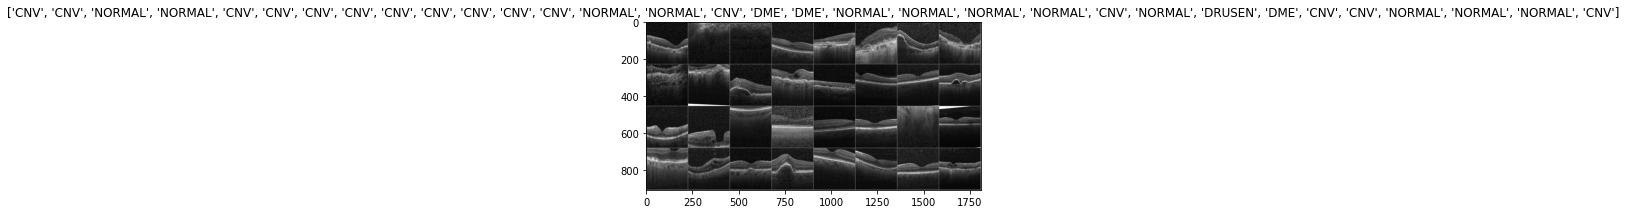

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5])
    std = np.array([0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
for id, data in enumerate(dataloaders['train']):
  print(id)
  img = data[0]
  label = data[1]
  print(img.shape)
  print(label.shape)
  break

0
torch.Size([32, 1, 224, 224])
torch.Size([32])


In [12]:
inputs = torch.Tensor(32, 1, 224, 224)
print('텐서의 크기 : {}'.format(inputs.shape))

텐서의 크기 : torch.Size([32, 1, 224, 224])


In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=60):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_losses = []
    train_accuracies = []

    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              train_losses.append(epoch_loss)
              train_accuracies.append(epoch_acc)

            if phase == 'val':
              val_losses.append(epoch_loss)
              val_accuracies.append(epoch_acc)

            # 1 epoch 마다 loss 출력
            x_train_losses = np.arange(len(train_losses))
            x_val_losses = np.arange(len(val_losses))
            plt.plot(x_train_losses, train_losses)
            plt.plot(x_val_losses, val_losses)            
            plt.xlabel('epochs')
            plt.ylabel('loss')
            plt.title('loss per epoch')
            plt.legend(['train', 'val'])
            plt.show()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)

    return model, train_losses, train_accuracies, val_losses, val_accuracies # 5개의 변수를 반환

In [14]:
model_ft = ResNet18()

#os.chdir('/content/drive/Shareddrives/ResNet18_Model_parameters')
# Present working directory
#!pwd
#PATH = 'ResNet18_retina.pth'->파일명에 따라서 다른이름으로 수정하여저장
# 학습된 모델 파라미터 로드
#model_ft.load_state_dict(torch.load(PATH))

In [15]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.1, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/59
----------


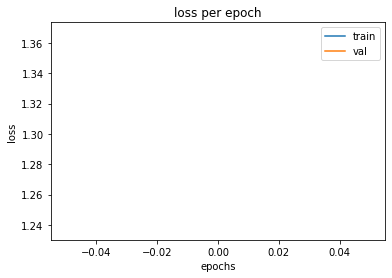

train Loss: 1.3018 Acc: 0.4394


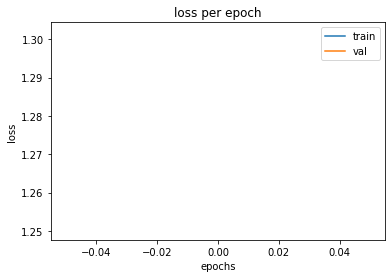

val Loss: 1.2502 Acc: 0.4425

Epoch 1/59
----------


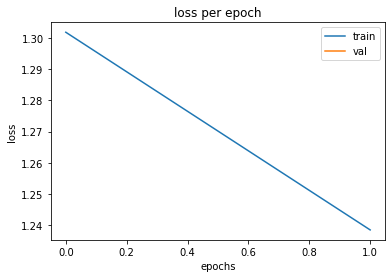

train Loss: 1.2385 Acc: 0.4393


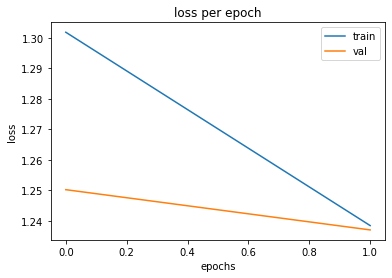

val Loss: 1.2371 Acc: 0.4429

Epoch 2/59
----------


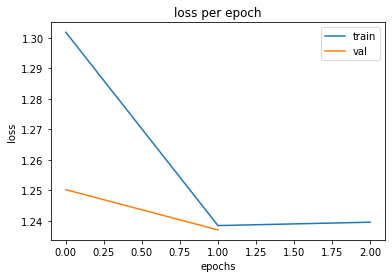

train Loss: 1.2396 Acc: 0.4393


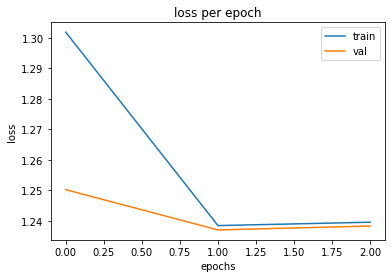

val Loss: 1.2383 Acc: 0.4425

Epoch 3/59
----------


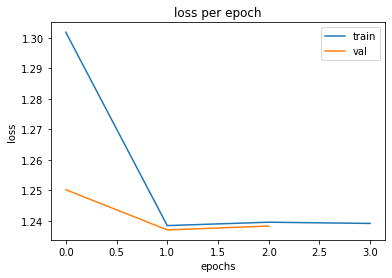

train Loss: 1.2392 Acc: 0.4344


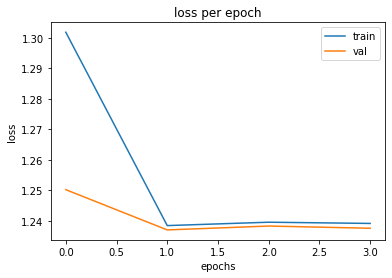

val Loss: 1.2376 Acc: 0.4429

Epoch 4/59
----------


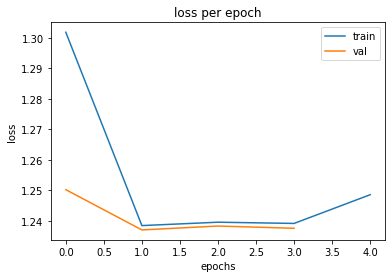

train Loss: 1.2486 Acc: 0.4402


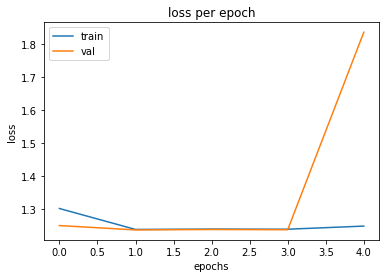

val Loss: 1.8352 Acc: 0.4425

Epoch 5/59
----------


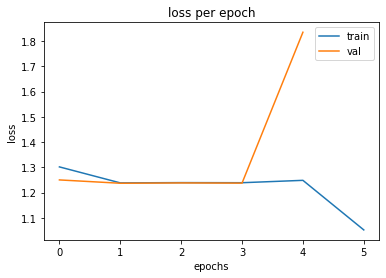

train Loss: 1.0522 Acc: 0.5916


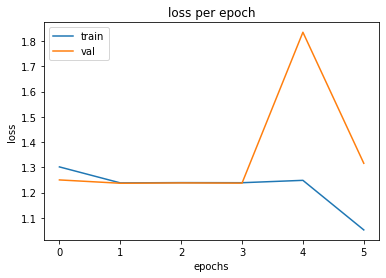

val Loss: 1.3161 Acc: 0.5263

Epoch 6/59
----------


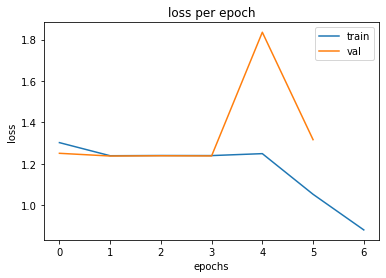

train Loss: 0.8801 Acc: 0.6718


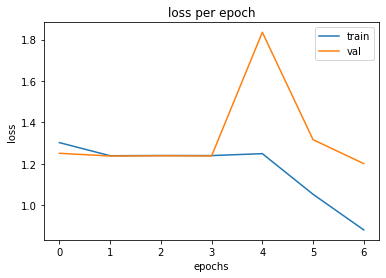

val Loss: 1.2003 Acc: 0.5802

Epoch 7/59
----------


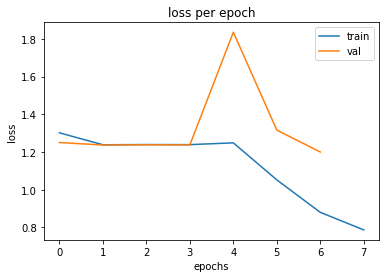

train Loss: 0.7869 Acc: 0.6952


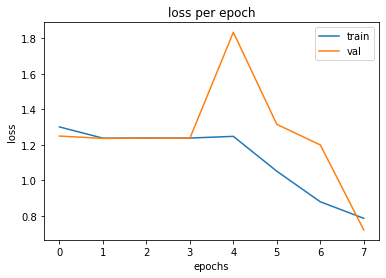

val Loss: 0.7215 Acc: 0.7072

Epoch 8/59
----------


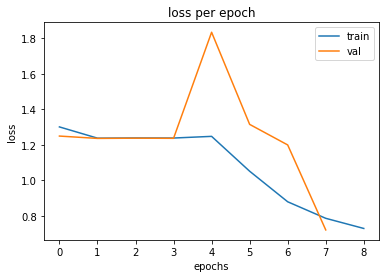

train Loss: 0.7298 Acc: 0.7159


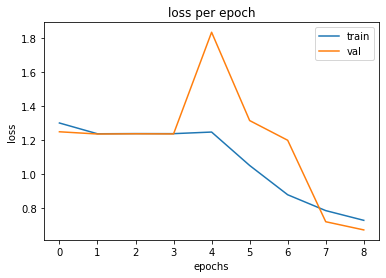

val Loss: 0.6735 Acc: 0.7331

Epoch 9/59
----------


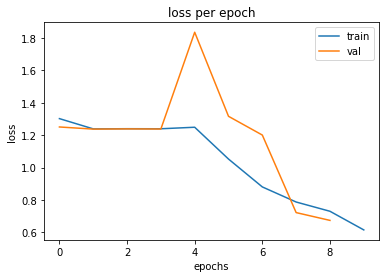

train Loss: 0.6146 Acc: 0.7577


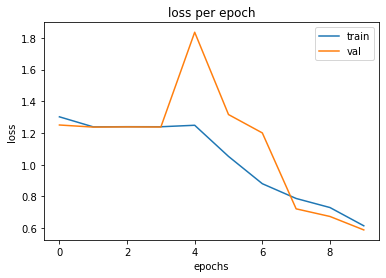

val Loss: 0.5886 Acc: 0.7722

Epoch 10/59
----------


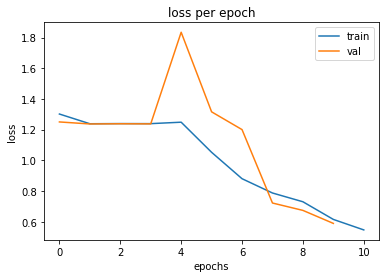

train Loss: 0.5462 Acc: 0.7922


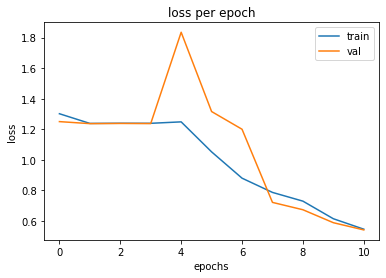

val Loss: 0.5414 Acc: 0.7963

Epoch 11/59
----------


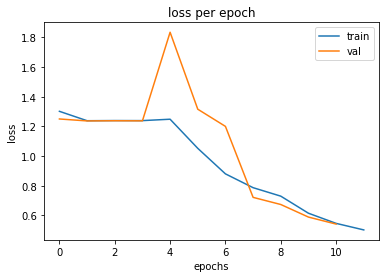

train Loss: 0.5020 Acc: 0.8097


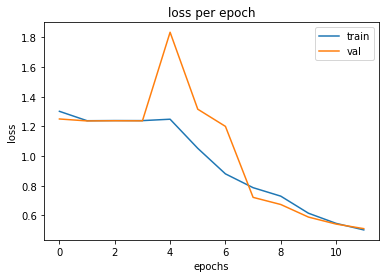

val Loss: 0.5107 Acc: 0.8073

Epoch 12/59
----------


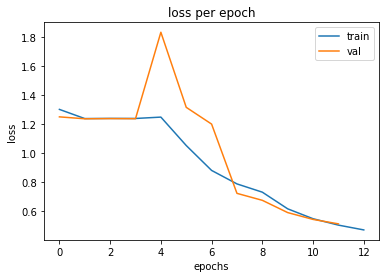

train Loss: 0.4689 Acc: 0.8251


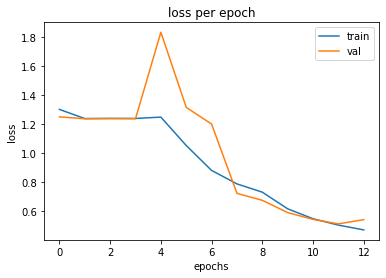

val Loss: 0.5398 Acc: 0.8020

Epoch 13/59
----------


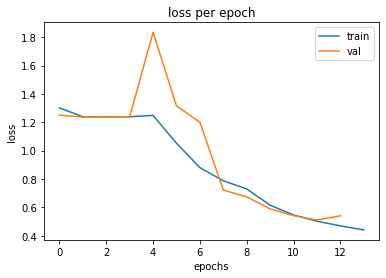

train Loss: 0.4405 Acc: 0.8354


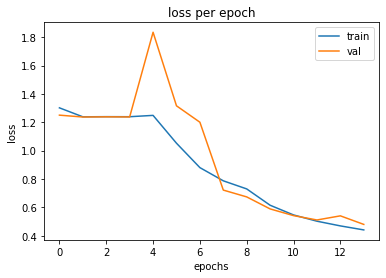

val Loss: 0.4794 Acc: 0.8158

Epoch 14/59
----------


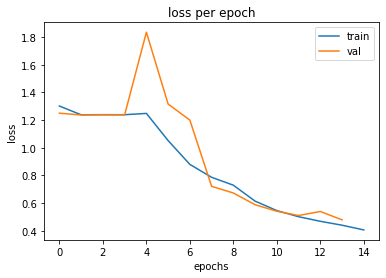

train Loss: 0.4066 Acc: 0.8462


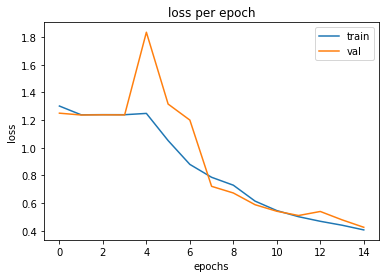

val Loss: 0.4255 Acc: 0.8400

Epoch 15/59
----------


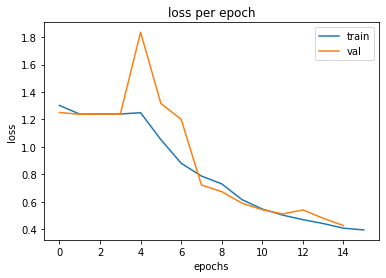

train Loss: 0.3942 Acc: 0.8544


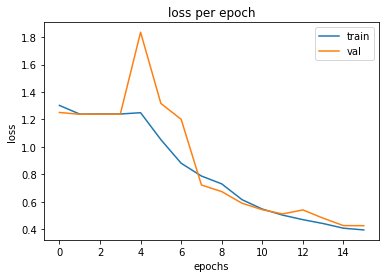

val Loss: 0.4250 Acc: 0.8481

Epoch 16/59
----------


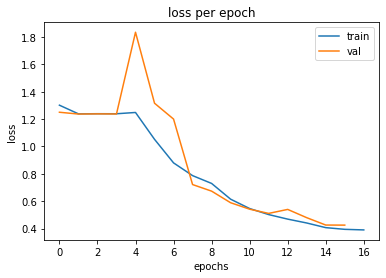

train Loss: 0.3899 Acc: 0.8558


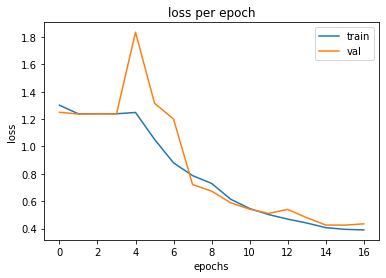

val Loss: 0.4343 Acc: 0.8414

Epoch 17/59
----------


In [ ]:
model_ft, train_losses, train_accuracies, val_losses, val_accuracies  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=60)

In [ ]:
os.chdir('/content/drive/Shareddrives/ResNet18_Model_parameters')

In [ ]:
# Present working directory
!pwd

In [ ]:
PATH = 'ResNet18_retina_Adam_60epochs_lr=0.1.pth'

In [ ]:
torch.save(model_ft.state_dict(), PATH)
print('Model Saved!')

In [ ]:
net = ResNet18()
net.load_state_dict(torch.load(PATH))

In [ ]:
net.to(device)

In [ ]:
def test_model(model, num_epochs=1):
    model.eval()
    since = time.time()

    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['test']:
            
            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.no_grad():
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
           

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

           
        print()

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Test Acc: {:4f}'.format(best_acc))


In [ ]:
test_model = test_model(net)